# Importing libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pdb





# Getting the data into useful forms
Note that I create extra columns to the dataframe so that the random effects model can run (it operates on a dataframe), but I also put the data into a numpy array called "x," because mathmatical operations will be faster on a numpy array rather than a pandas dataframe of this size.

In [89]:
#Loading the data
df = pd.read_csv('cheese.csv')

#Adding the columns of interest
df['logprice'] = np.log(df['price'])
df['logprice_disp'] = np.log(df['price'])*df['disp']
df['logvol'] = np.log(df['vol'])



#Creating a numpy array with the matrix of values
#The first column is identically one for an intercept
x = np.ones((len(df), 4))
#The second column is the log of the price
x[:,1] = df['logprice']
#The third column is the display boolean variable
x[:,2] = df['disp']
#The fourth column is the interaction variable between price and display
x[:,3] = df['logprice_disp']

#y is the vector of responses
y = np.array(df['logvol'])


#Creating a list of store indices (called "store") for each element in x
store_list = np.unique(df['store'])
store_lookup = dict(zip(store_list, range(len(store_list))))
store = np.array(df.store.replace(store_lookup).values)

# Method 1: Empirical Bayes using LMER equivalent in python 

In [3]:
model = sm.MixedLM.from_formula("logvol ~ (logprice + disp + logprice_disp)", df, re_formula="logprice + disp + logprice_disp", groups=df["store"])
result = model.fit()
print(result.summary())

/home/tyler/venv/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      logvol   
No. Observations:        5555         Method:                  REML     
No. Groups:              88           Scale:                   0.0673   
Min. group size:         52           Likelihood:              -832.4408
Max. group size:         68           Converged:               Yes      
Mean group size:         63.1                                           
------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                    10.240    0.156  65.799 0.000  9.935 10.545
logprice                     -2.123    0.125 -16.918 0.000 -2.369 -1.877
disp                          0.439    0.157   2.794 0.005  0.131  0.746
logprice_disp                -0.236    0.146  -1.611 0.107 -0.522  0.

In [4]:
lmer_df = pd.DataFrame.from_dict(result.random_effects, orient='index')
lmer_df = lmer_df.rename(columns={'Group':'Intercept'})
lmer_df['store'] = lmer_df.index

for i in result.fe_params.keys():
    lmer_df[i] = lmer_df[i] + result.fe_params[i]


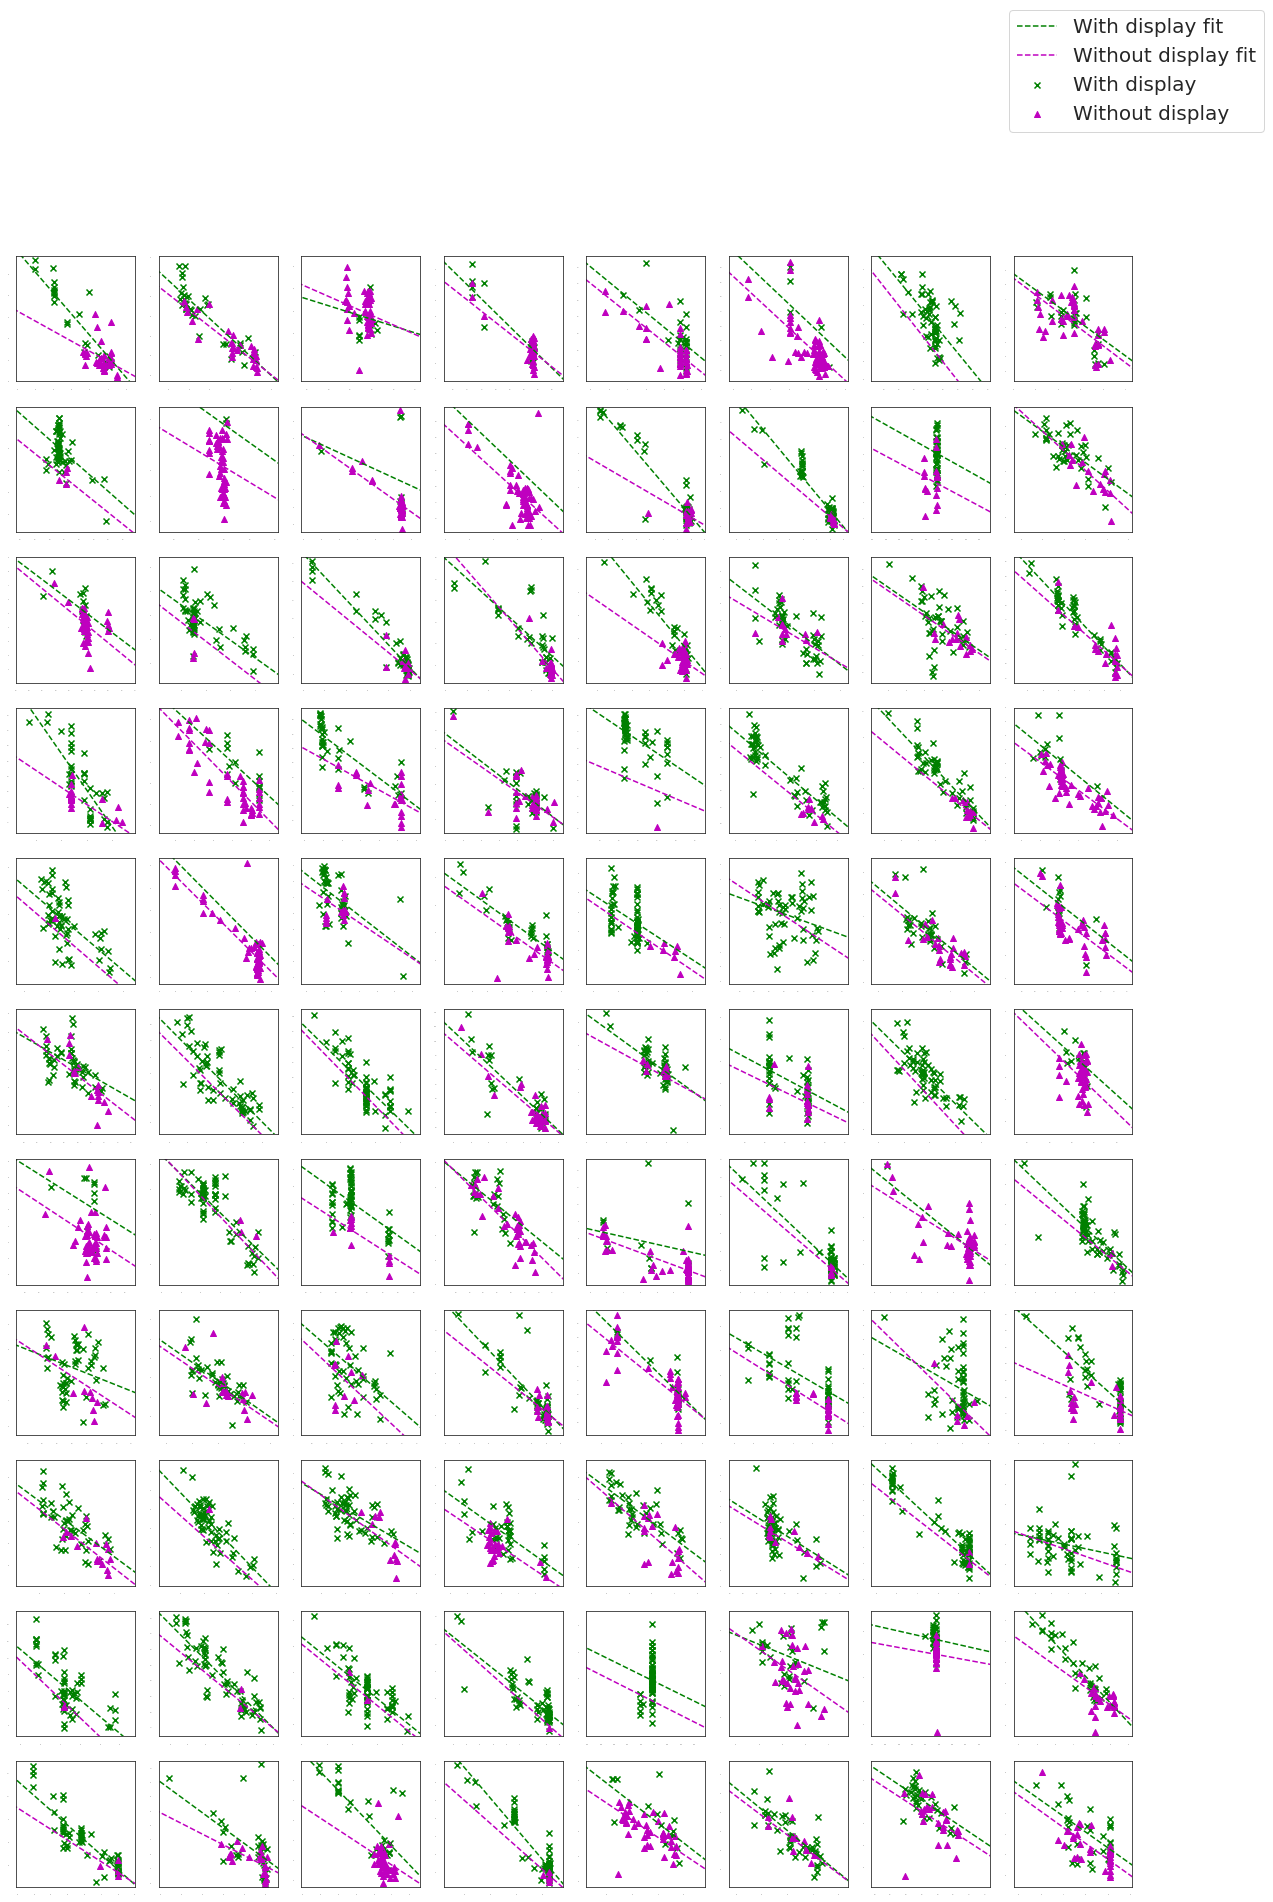

In [5]:
#Making plots
plt.rcParams['figure.figsize'] = [20, 30]
plt.rc('xtick', labelsize=0) 
plt.rc('ytick', labelsize=0) 
sns.set_style('white')
for i in range(len(lmer_df)):
    xslice = lmer_df.iloc[i]
    plt.subplot(11,8,i+1)
    store_subset = df[df['store']==xslice['store']]
    disp = store_subset[store_subset['disp']==1]
    no_disp = store_subset[store_subset['disp']==0]
    plt.scatter(disp['logprice'],disp['logvol'], marker='x', color='g')
    plt.scatter(no_disp['logprice'],no_disp['logvol'], marker='^', color='m')
    plt.plot(np.linspace(0,20), np.linspace(0,20)*(xslice['logprice']+xslice['logprice_disp'])+xslice['Intercept']+xslice['disp'], 
            color='g', linestyle='--')
    plt.plot(np.linspace(0,20), np.linspace(0,20)*xslice['logprice']+xslice['Intercept'], 
            color='m', linestyle='--')

#     plt.xlim([.27,1.54])
#     plt.ylim([5.4,11.91])
    plt.xlim([np.min(store_subset['logprice'])-.1,np.max(store_subset['logprice'])+.1 ])
    plt.ylim([np.min(store_subset['logvol'])-.1,np.max(store_subset['logvol'])+.1])

#     plt.xlabel('log(price)')
#     plt.ylabel('log(volume)')

plt.figlegend(['With display fit', 'Without display fit', 'With display', 'Without display'],prop={'size': 20},
             loc=1)

mu

In [6]:
#Setting up priors for the betas based on the mixed model results
mu = [np.mean(lmer_df.iloc[:,i]) for i in range(4)]
precisions = [1.0/np.var(lmer_df.iloc[:,i]) for i in range(4)]
tau = np.diag(precisions)
tau_inv = np.linalg.inv(tau)



# Method 2: Gibbs sampler but using mixed effects model to inform priors

In [65]:
num_iter = 2000
beta_trace = np.zeros([len(store_list),num_iter,4])
sigma2_trace = np.zeros([len(store_list),num_iter])



for i in range(len(store_list)):
    xi = x[store==i,:]
    yi = y[store==i]
    ni = len(yi)

    beta_trace[i,0,:] = mu
    #Arbitrary starting point
    sigma2_trace[i,0] = 1.0

    for j in range(1,num_iter):
        #Calculate k_star and m_star
        k_star_inv = np.linalg.inv((1/sigma2_trace[i,j-1])*xi.transpose()@xi + tau)
        m_star = k_star_inv@((1/sigma2_trace[i,j-1])*xi.transpose()@yi + tau@mu)
        #Then draw new beta
        beta_trace[i,j,:] = np.random.multivariate_normal(m_star, k_star_inv)


        #calculate a and b
        a = ni/2.0
        b = .5*(yi-xi@beta_trace[i,j,:]).transpose()@(yi-xi@beta_trace[i,j,:])
        #Draw new sigma_2
        sigma2_trace[i,j] = 1.0/np.random.gamma(a,1.0/b)

    
    
    
    
    
    



In [74]:
#Packaging the sampler results into a dataframe so I can rerun the plotmaker easily
d = {
    'Intercept': [np.mean(beta_trace[i,:,0]) for i in range(len(store_list))],
    'logprice': [np.mean(beta_trace[i,:,1]) for i in range(len(store_list))],
    'disp': [np.mean(beta_trace[i,:,2]) for i in range(len(store_list))],
    'logprice_disp': [np.mean(beta_trace[i,:,3]) for i in range(len(store_list))],
    'store': store_list
}
gibbs_df = pd.DataFrame(d)



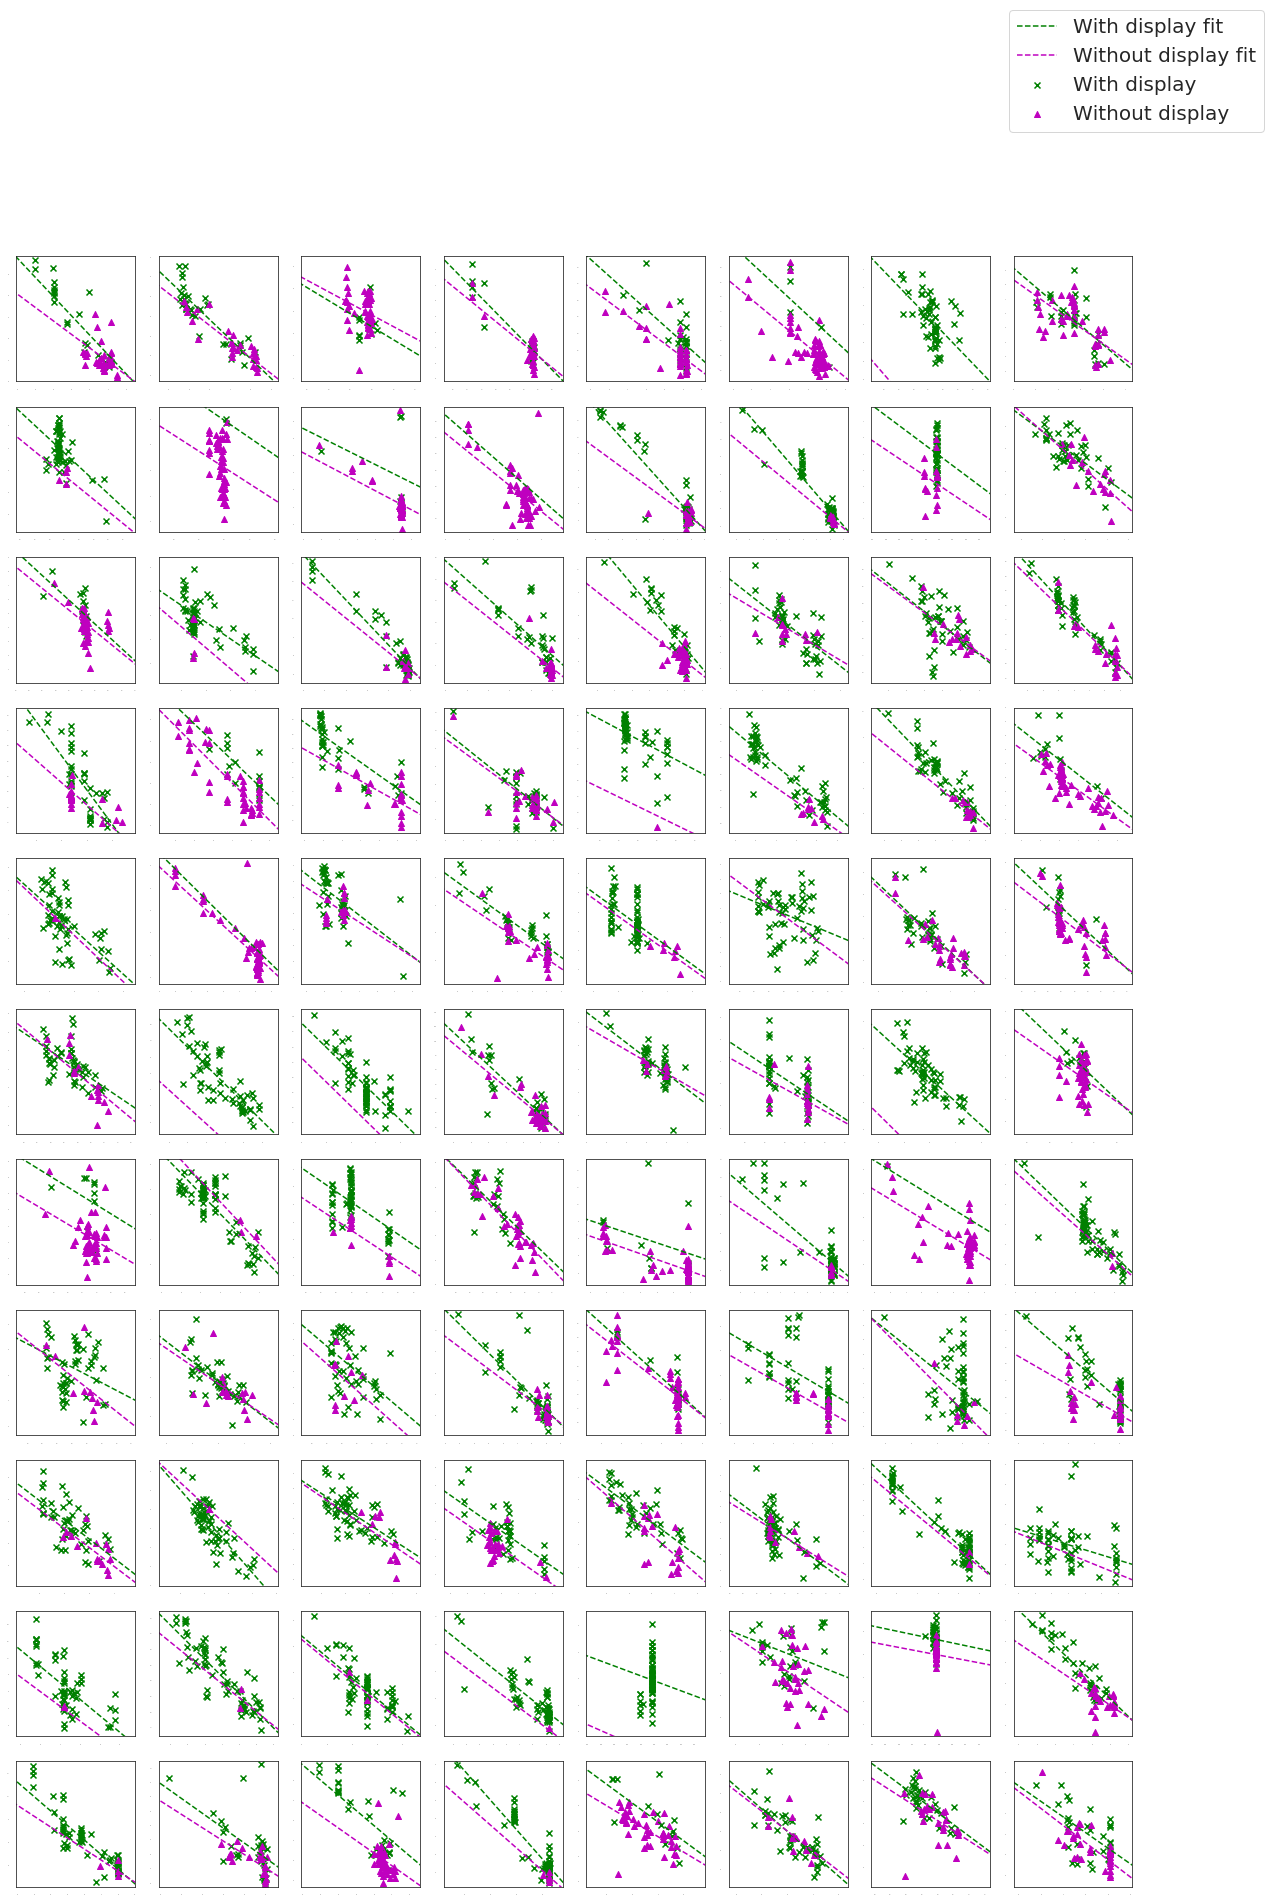

In [75]:
#Making plots
plt.rcParams['figure.figsize'] = [20, 30]
plt.rc('xtick', labelsize=0) 
plt.rc('ytick', labelsize=0) 
sns.set_style('white')
for i in range(len(gibbs_df)):
    xslice = gibbs_df.iloc[i]
    plt.subplot(11,8,i+1)
    store_subset = df[df['store']==xslice['store']]
    disp = store_subset[store_subset['disp']==1]
    no_disp = store_subset[store_subset['disp']==0]
    plt.scatter(disp['logprice'],disp['logvol'], marker='x', color='g')
    plt.scatter(no_disp['logprice'],no_disp['logvol'], marker='^', color='m')
    plt.plot(np.linspace(0,20), np.linspace(0,20)*(xslice['logprice']+xslice['logprice_disp'])+xslice['Intercept']+xslice['disp'], 
            color='g', linestyle='--')
    plt.plot(np.linspace(0,20), np.linspace(0,20)*xslice['logprice']+xslice['Intercept'], 
            color='m', linestyle='--')

#     plt.xlim([.27,1.54])
#     plt.ylim([5.4,11.91])
    plt.xlim([np.min(store_subset['logprice'])-.1,np.max(store_subset['logprice'])+.1 ])
    plt.ylim([np.min(store_subset['logvol'])-.1,np.max(store_subset['logvol'])+.1])

#     plt.xlabel('log(price)')
#     plt.ylabel('log(volume)')

plt.figlegend(['With display fit', 'Without display fit', 'With display', 'Without display'],prop={'size': 20},
             loc=1)


Notice that in general the results are similar to those of the mixed effects model, but in some cases, they differ significantly. For example, in the second rom from the bottom, the fifth plot has no datapoints without display. This causes the gibbs sampler to give a weird fit for the no display value because it resorts to the prior mean slope for this fit, but the mixed effect model falls back on the mean difference of slopes, which is much smaller. 

# Method 3: Using pymc3 for Gibbs sampling

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import pdb
from theano import tensor as T
import scipy as sp


#Creating numpy arrays to hold the x and y data
logQ = np.array(np.log(df['vol']))

x = np.ones((len(df),4))
x[:,1] = np.array(np.log(df['price']))
x[:,2] = np.array(df['disp'])
x[:,3] = np.array(x[:,2]*x[:,1])

x[:,1] = np.array(np.log(df['price']))

#creating a lookup table for store
stores = np.unique(df['store'])
store_lookup = dict(zip(stores, range(len(stores))))
store = np.array(df.store.replace(store_lookup).values)
n_stores = len(stores)

with pm.Model() as model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    mu_c = pm.Normal('mu_c', mu=0., sd=100**2)
    sigma_c = pm.HalfCauchy('sigma_c', 5)
    mu_d = pm.Normal('mu_d', mu=0., sd=100**2)
    sigma_d = pm.HalfCauchy('sigma_d', 5)

    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_stores)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)

    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=n_stores)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)

    c_offset = pm.Normal('c_offset', mu=0, sd=1, shape=n_stores)
    c = pm.Deterministic("c", mu_c + c_offset * sigma_c)

    d_offset = pm.Normal('d_offset', mu=0, sd=1, shape=n_stores)
    d = pm.Deterministic("d", mu_d + d_offset * sigma_d)

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    store_est = a[store] + b[store]*x[:,1] + c[store]*x[:,2] + d[store]*x[:,3]

    # Data likelihood
    like = pm.Normal('like', mu=store_est, sd=eps, observed=logQ)

    trace = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, d_offset, c_offset, b_offset, a_offset, sigma_d, mu_d, sigma_c, mu_c, sigma_b, mu_b, sigma_a, mu_a]
Sampling 4 chains: 100%|██████████| 8000/8000 [03:57<00:00,  8.90draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [83]:
#Packaging the sampler results into a dataframe so I can rerun the plotmaker easily
d = {
    'Intercept': [np.mean(trace['a'][:,i]) for i in range(len(trace['d'][0,:]))],
    'logprice': [np.mean(trace['b'][:,i]) for i in range(len(trace['b'][0,:]))],
    'disp': [np.mean(trace['c'][:,i]) for i in range(len(trace['c'][0,:]))],
    'logprice_disp': [np.mean(trace['d'][:,i]) for i in range(len(trace['d'][0,:]))],
    'store': store_list
}
pymc_df = pd.DataFrame(d)


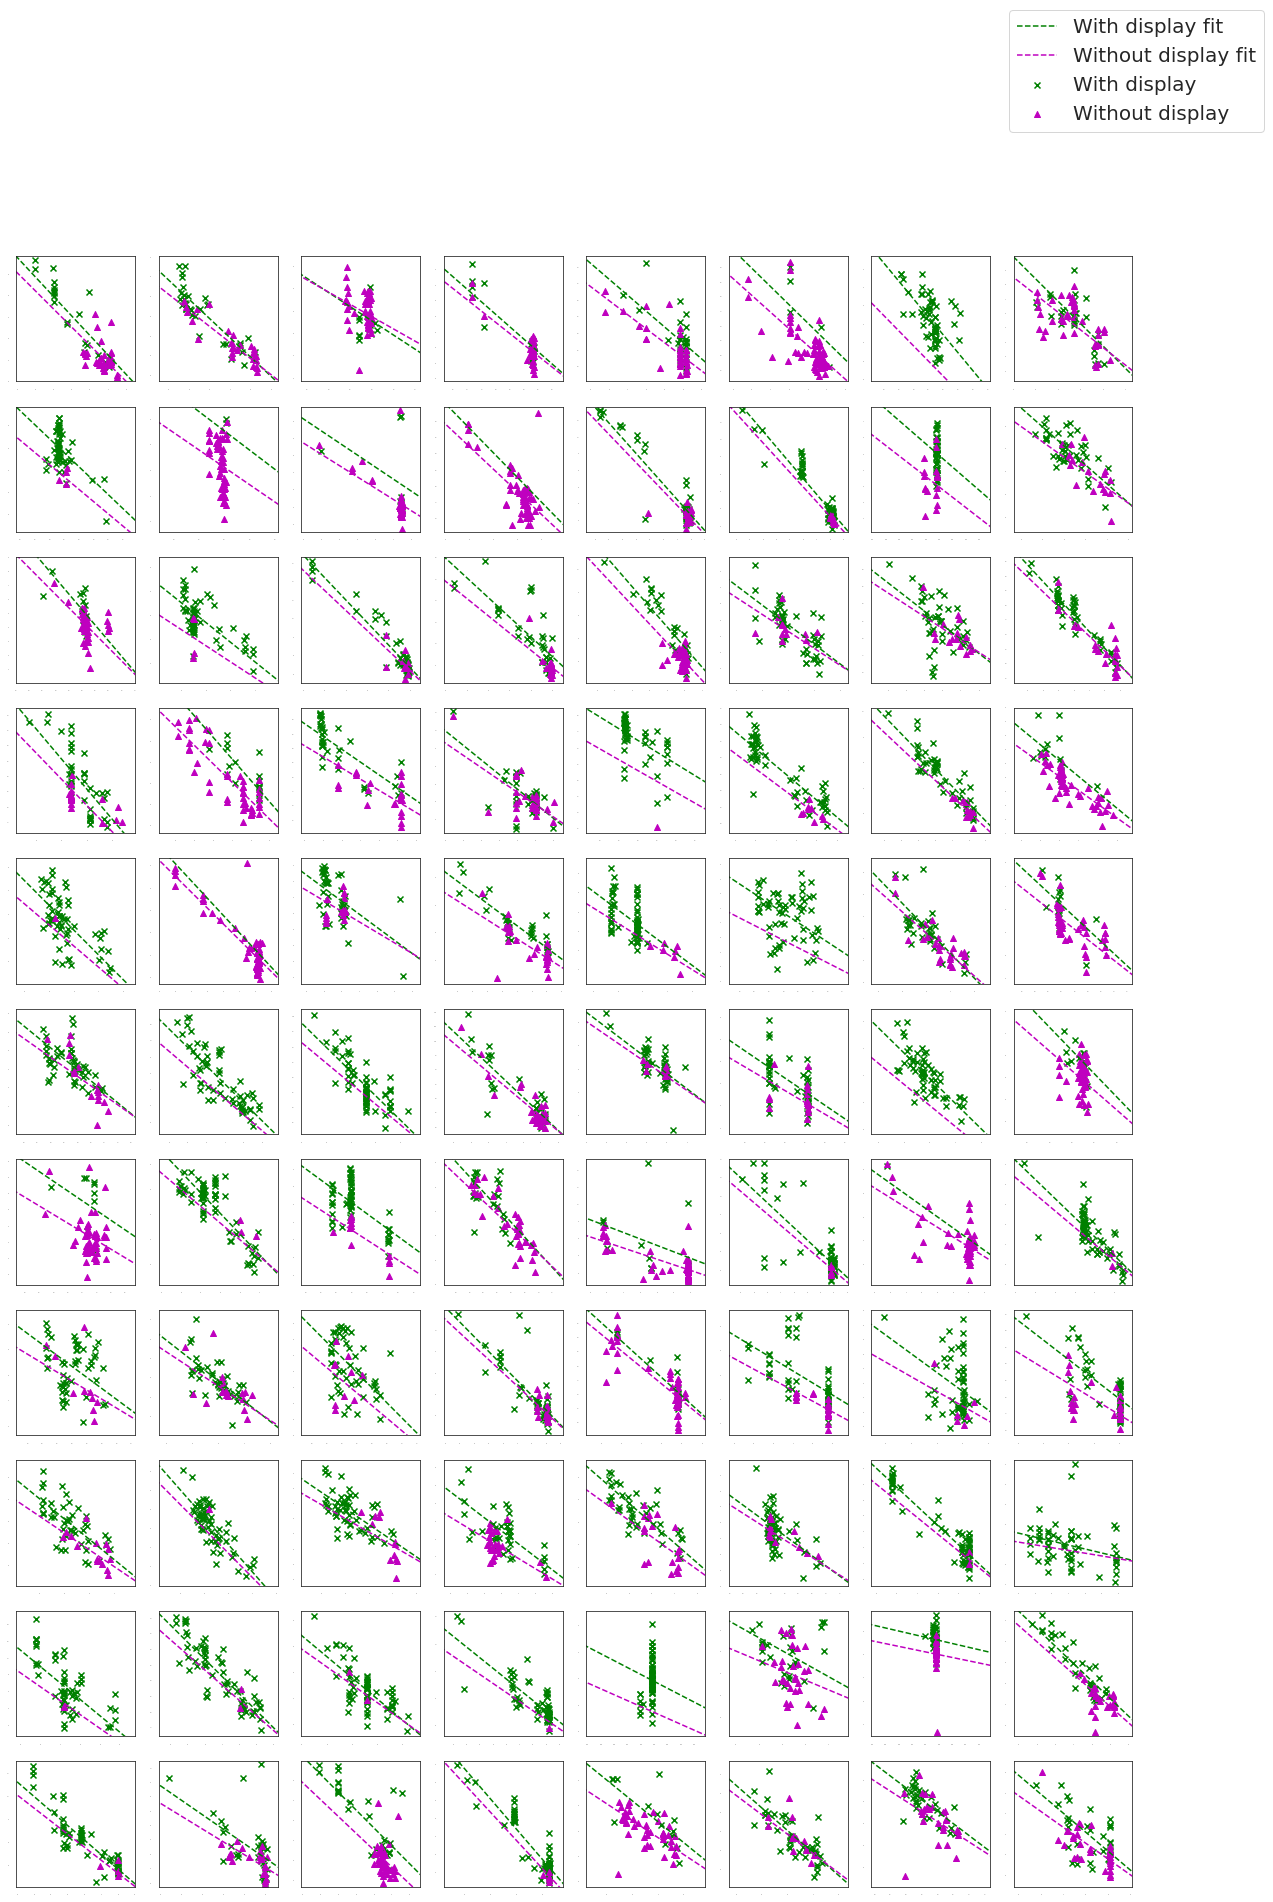

In [90]:
#Making plots
plt.rcParams['figure.figsize'] = [20, 30]
plt.rc('xtick', labelsize=0) 
plt.rc('ytick', labelsize=0) 
sns.set_style('white')
for i in range(len(pymc_df)):
    xslice = pymc_df.iloc[i]
    plt.subplot(11,8,i+1)
    store_subset = df[df['store']==xslice['store']]
    disp = store_subset[store_subset['disp']==1]
    no_disp = store_subset[store_subset['disp']==0]
    plt.scatter(disp['logprice'],disp['logvol'], marker='x', color='g')
    plt.scatter(no_disp['logprice'],no_disp['logvol'], marker='^', color='m')
    plt.plot(np.linspace(0,20), np.linspace(0,20)*(xslice['logprice']+xslice['logprice_disp'])+xslice['Intercept']+xslice['disp'], 
            color='g', linestyle='--')
    plt.plot(np.linspace(0,20), np.linspace(0,20)*xslice['logprice']+xslice['Intercept'], 
            color='m', linestyle='--')

#     plt.xlim([.27,1.54])
#     plt.ylim([5.4,11.91])
    plt.xlim([np.min(store_subset['logprice'])-.1,np.max(store_subset['logprice'])+.1 ])
    plt.ylim([np.min(store_subset['logvol'])-.1,np.max(store_subset['logvol'])+.1])

#     plt.xlabel('log(price)')
#     plt.ylabel('log(volume)')

plt.figlegend(['With display fit', 'Without display fit', 'With display', 'Without display'],prop={'size': 20},
             loc=1)